In [1]:
#import the required libraries
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras import backend as K
from keras.datasets import cifar10
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
num_classes = 10
batch_size= 16
epochs=50

# loading Cifar-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#Train-validation-test split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)
#Display the size of the CIFAR10 dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))
#Onehot Encoding the labels (convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
#Convert data into float32
x_train = x_train.astype('float32')

x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
#Normalize the data so that it will be scaled to range of 0 to 1
x_train /= 255
x_val /=255
x_test /= 255
#Display the size of the dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))
((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [3]:
# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

c:\envs\Deepbook\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,762 (1010.79 KB)

 Trainable params: 258,762 (1010.79 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
optimizer = Adam(learning_rate=0.001)

#early stopping to monitor the validation loss and avoid overfitting
#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

# Compile the model
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

#Training the model
#The .fit() function is used when the entire training dataset can fit into the memory and no data augmentation is applied
history = model.fit(x_train, y_train,
              batch_size=50,
              epochs=100,
              validation_data=(x_val,y_val),
              callbacks=[rlrop],
              shuffle=True,
              verbose=1)

Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2996 - loss: 1.8625 - val_accuracy: 0.5119 - val_loss: 1.3407 - learning_rate: 0.0010
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5425 - loss: 1.2668 - val_accuracy: 0.5981 - val_loss: 1.1341 - learning_rate: 0.0010
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6149 - loss: 1.0784 - val_accuracy: 0.6299 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6679 - loss: 0.9443 - val_accuracy: 0.6542 - val_loss: 0.9902 - learning_rate: 0.0010
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7124 - loss: 0.8217 - val_accuracy: 0.6510 - val_loss: 1.0012 - learning_rate: 0.0010
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7426 - loss: 0.7297 - val_accuracy: 0.6852 - val_loss: 0.9124 - learning_rate: 0.0010
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7673 - loss: 0.

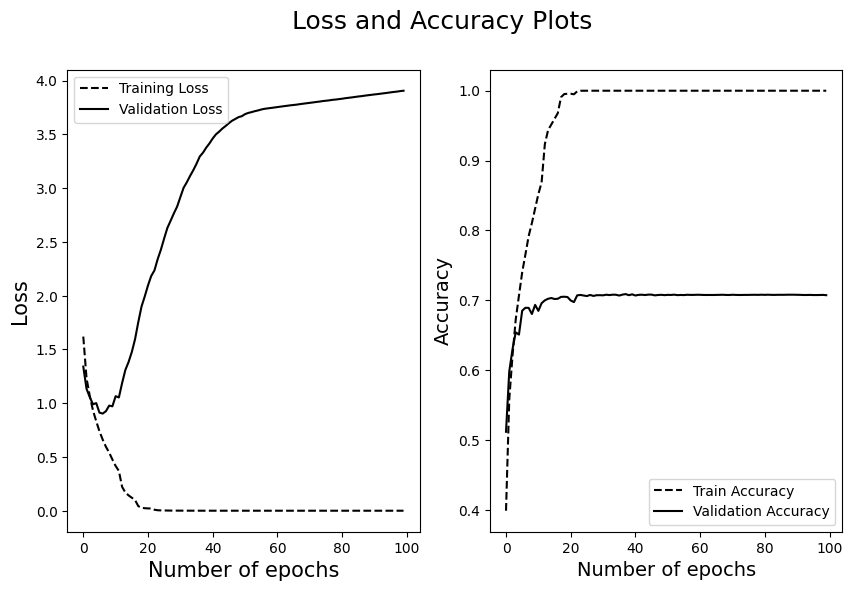

In [5]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(10,6))
plt.suptitle('Loss and Accuracy Plots', fontsize=18)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss',color='black', linestyle='dashed')
plt.plot(history.history['val_loss'], label='Validation Loss',color='black')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy',color='black', linestyle='dashed')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',color='black')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.savefig('Data/loss_acc_cnn.pdf')
plt.show()




In [6]:
#Save the model in an H5 file
model.save('models/model_cnn.h5')
del model

In [7]:
#Load the saved model with the same architecture and weights.
model = load_model("models/model_cnn.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


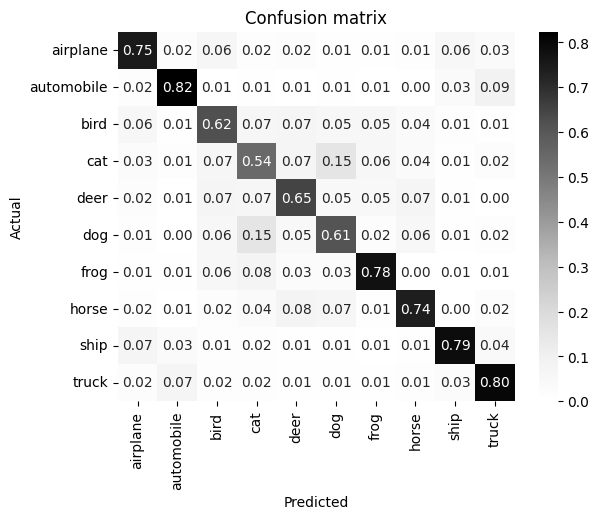

In [8]:
import numpy as np
#Plotting the confusion matrix
y_test=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(x_test),axis=1)
cm=confusion_matrix(y_test,y_pred)
classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True,
            fmt='.2f', xticklabels=classes, cbar=True, yticklabels=classes,cmap='Greys')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Data/confusion_cnn.pdf')
plt.show()


In [9]:
#Classification accuracy
acc_score = accuracy_score(y_test, y_pred)
print('Accuracy Score = ', acc_score)

Accuracy Score =  0.7109
